In [1]:
import numpy as np # linear algebra
np.random.seed(1337) #reproducibility
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import os
import pandas as pd
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import gc
import IPython.display as ipd 

In [3]:
train_path = "./train/train/"
test_path = "./test/test/"

In [4]:
filename = 'de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.flac'

In [5]:
data, samplerate = sf.read(train_path+filename)

In [6]:
import gc
gc.collect()

0

In [7]:
data.shape

(220500,)

In [8]:
data[:10];samplerate

22050

In [9]:
ipd.Audio(train_path+filename)

Text(0.5, 0, 'Time [sec]')

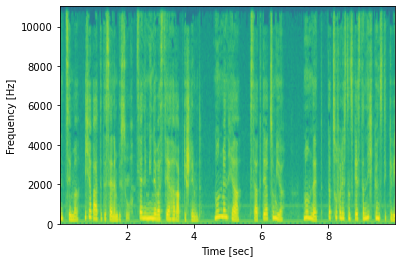

In [10]:
Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)

# add axis labels
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time in samples')

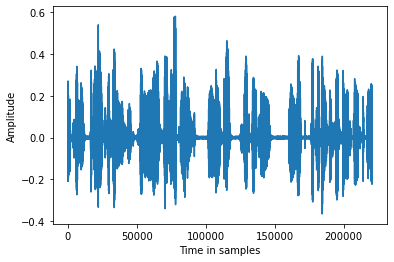

In [11]:
plt.plot(data)

# add axis labels
plt.ylabel('Amplitude')
plt.xlabel('Time in samples')

In [12]:
filename[:2]

'de'

In [13]:
label = []
for filename in os.listdir(train_path):
    label.append(filename[:2])
#language is in first 2 primary elements

In [14]:
label_t = []
for filename in os.listdir(test_path):
    label_t.append(filename[:2])

In [15]:
print(len(label))
print(len(label_t))

73080
540


In [16]:
file = []
for filename in os.listdir(train_path):
    file.append(filename)

In [17]:
file_t = []
for filename in os.listdir(test_path):
    file_t.append(filename)

In [18]:
Label = pd.DataFrame(label,columns=['Language'])

In [19]:
Label['Language'].value_counts()

de    24360
en    24360
es    24360
Name: Language, dtype: int64

In [20]:
data = {'filename':file,
       'languange':label}

In [21]:
data_t = {'filename':file_t,
       'languange':label_t}

In [22]:
df = pd.DataFrame(data)

In [23]:
df_t = pd.DataFrame(data_t)

In [24]:
df['filename'][0]

'de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.flac'

In [25]:
# extracted from https://github.com/tomasz-oponowicz/spoken_language_identification
def generate_fb_and_mfcc(signal, sample_rate):

    # Pre-Emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01

    # Convert from seconds to samples
    frame_length, frame_step = (
        frame_size * sample_rate,
        frame_stride * sample_rate)
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Make sure that we have at least 1 frame
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))

    # Pad Signal to make sure that all frames have equal
    # number of samples without truncating any samples
    # from the original signal
    pad_signal = np.append(emphasized_signal, z)

    indices = (
        np.tile(np.arange(0, frame_length), (num_frames, 1)) +
        np.tile(
            np.arange(0, num_frames * frame_step, frame_step),
            (frame_length, 1)
        ).T
    )
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Window
    frames *= np.hamming(frame_length)

    # Fourier-Transform and Power Spectrum
    NFFT = 512

    # Magnitude of the FFT
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # Power Spectrum
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Filter Banks
    nfilt = 40

    low_freq_mel = 0

    # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))

    # Equally spaced in Mel scale
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

    # Convert Mel to Hz
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)

    # Numerical Stability
    filter_banks = np.where(
        filter_banks == 0,
        np.finfo(float).eps,
        filter_banks)

    # dB
    filter_banks = 20 * np.log10(filter_banks)

    # MFCCs
    # num_ceps = 12
    # cep_lifter = 22

    # ### Keep 2-13
    # mfcc = dct(
    #     filter_banks,
    #     type=2,
    #     axis=1,
    #     norm='ortho'
    # )[:, 1 : (num_ceps + 1)]

    # (nframes, ncoeff) = mfcc.shape
    # n = np.arange(ncoeff)
    # lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    # mfcc *= lift
    #filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    
    return filter_banks


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train,X_test,y_train,y_test = train_test_split(df,df['languange'],stratify = df['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

en    12180
de    12180
es    12180
Name: languange, dtype: int64
es    12180
en    12180
de    12180
Name: languange, dtype: int64


In [28]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

en    6090
de    6090
es    6090
Name: languange, dtype: int64
en    6090
de    6090
es    6090
Name: languange, dtype: int64


In [29]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

de    3045
en    3045
es    3045
Name: languange, dtype: int64
es    3045
en    3045
de    3045
Name: languange, dtype: int64


In [30]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.6,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

en    1218
es    1218
de    1218
Name: languange, dtype: int64
en    1827
de    1827
es    1827
Name: languange, dtype: int64


In [31]:
X_train['filename'].values[:2]

array(['en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment7.speed2.flac',
       'en_m_f7d28f7498eaf373b312abcdc0886951.fragment23.pitch4.flac'],
      dtype=object)

In [32]:
X_train.head()

,filename,languange
40825,en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment...,en
48301,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en
40158,en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment...,en
28526,en_f_31da456c78eb5cf86d2b447e2fbfb736.fragment...,en
68273,es_m_b53274d3ef7996a22d6ec929c1869804.fragment...,es


In [33]:
#we reset the indices
X_train = X_train.reset_index(drop = True)
X_train.head()

,filename,languange
0,en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment...,en
1,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en
2,en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment...,en
3,en_f_31da456c78eb5cf86d2b447e2fbfb736.fragment...,en
4,es_m_b53274d3ef7996a22d6ec929c1869804.fragment...,es


In [34]:
gc.collect()

0

In [35]:
series = []
length = []
for filename in X_train['filename'].values:
    flac, samplerate = sf.read(train_path+filename)
    series.append(flac)
    length.append(samplerate)

In [36]:
X_train['Series'] = series
X_train['Length'] = length
X_train.head(20)

,filename,languange,Series,Length
0,en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment...,en,"[0.161285400390625, 0.26153564453125, 0.228332...",22050
1,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en,"[0.00030517578125, 0.00030517578125, 0.0001831...",22050
2,en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment...,en,"[0.12261962890625, 0.182342529296875, 0.131866...",22050
3,en_f_31da456c78eb5cf86d2b447e2fbfb736.fragment...,en,"[0.00634765625, 0.019805908203125, 0.006439208...",22050
4,es_m_b53274d3ef7996a22d6ec929c1869804.fragment...,es,"[0.001617431640625, 0.001739501953125, 0.00186...",22050
5,en_f_cb90542ae2fd3247d519634c2f9e53a8.fragment...,en,"[0.020263671875, 0.02337646484375, 0.025634765...",22050
6,es_m_534a0cf6f6aea8e35667a9147d2d0f8d.fragment...,es,"[-3.0517578125e-05, -3.0517578125e-05, 3.05175...",22050
7,es_m_9d8242673cefba8a44695b3d4f4ddd3f.fragment...,es,"[0.01708984375, 0.009490966796875, -0.00436401...",22050
8,es_m_534a0cf6f6aea8e35667a9147d2d0f8d.fragment...,es,"[0.00787353515625, 0.00970458984375, 0.0080871...",22050
9,en_m_65733942d40b2431cf22fe21495693f7.fragment...,en,"[-0.012115478515625, -0.0196533203125, -0.0200...",22050


In [37]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [38]:
gc.collect()

0

In [39]:
#  generate filter banks and mfccs for train
MFCC_array = []
for i in range(0,len(X_train)):
    MFCC = generate_fb_and_mfcc(X_train['Series'][i], X_train['Length'][i])
    MFCC_sc = sc.fit_transform(MFCC)
    MFCC_array.append(MFCC_sc)
MFCC_array = np.array(MFCC_array)  

In [40]:
np.save('./working/MFCC_data',MFCC_array)

In [41]:
series_t = []
length_t = []
for filename in df_t['filename'].values:
    flac, samplerate = sf.read(test_path+filename)
    series_t.append(flac)
    length_t.append(samplerate)

In [42]:
df_t['Series'] = series_t
df_t['Length'] = length_t
df_t.head()

,filename,languange,Series,Length
0,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,"[0.00274658203125, 0.004486083984375, 0.010803...",22050
1,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,"[0.07891845703125, 0.09246826171875, 0.1100769...",22050
2,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,"[-0.007354736328125, -0.007415771484375, -0.00...",22050
3,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,"[0.038848876953125, 0.04473876953125, 0.055511...",22050
4,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,"[0.000335693359375, -0.000244140625, 0.0032043...",22050


In [43]:
# generate filter banks and mfccs for test
MFCC_array_t = []
for i in range(0,len(df_t)):
    MFCC = generate_fb_and_mfcc(df_t['Series'][i], df_t['Length'][i])
    MFCC_sc = sc.fit_transform(MFCC)
    MFCC_array_t.append(MFCC_sc)
MFCC_array_t = np.array(MFCC_array_t)

In [44]:
np.save('./working/MFCC_data_t',MFCC_array_t)

In [45]:
# one hot encoding
language_dummies = pd.get_dummies(X_train['languange'])
language_dummies_t = pd.get_dummies(df_t['languange'])
np.save('./working/language_dummy',language_dummies.values)
np.save('./working/language_dummy_t',language_dummies_t.values)

In [46]:
import librosa
import librosa.display

C:\Users\Lenovo\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [47]:
MFCC_array = np.load('./working/MFCC_data.npy')

In [48]:
language_dummies = np.load('./working/language_dummy.npy')
language_dummies_t = np.load('./working/language_dummy_t.npy')

In [49]:
language_dummies_t[:5]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [50]:
X_train_MFCC,X_test_MFCC,y_train_MFCC,y_test_MFCC = train_test_split(MFCC_array,language_dummies,stratify = language_dummies,test_size = 0.10,random_state = 0)

In [51]:
X_train_MFCC.shape

(3288, 1000, 40)

In [52]:
X_train_MFCC = X_train_MFCC.reshape(-1,1000,40,1)

In [53]:
X_test_MFCC = X_test_MFCC.reshape(-1,1000,40,1)

In [54]:
y_train_MFCC 
y_test_MFCC
len(X_train_MFCC)

3288

In [55]:
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix

from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from keras.layers import Dropout, Input, Activation
from keras.optimizers import Nadam, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.layers import BatchNormalization
from keras import regularizers


In [94]:
input_shape = (1000,40,1)
model = Sequential()
model.add(Conv2D(32,(7, 7), activation='relu', padding='valid', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64,(5,5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))




import math
from keras.callbacks import LearningRateScheduler
adam = Adam()
def step_decay(epoch):
    # 00158 = 90.4%
	initial_lrate = 0.00158
	drop = 0.9
	epochs_drop = 10
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



checkpoint = ModelCheckpoint(
                'model.h5',
                monitor='val_acc',
                verbose=0,
                save_best_only=True,
                mode='max'
                )

lrate = LearningRateScheduler(step_decay)
#es = EarlyStopping(monitor='val_loss',mode = 'max')
model.fit(
                X_train_MFCC,
                y_train_MFCC,
                epochs=10,
                callbacks=[checkpoint, lrate],
                verbose=1,
                validation_data=(X_test_MFCC, y_test_MFCC),
                batch_size=32)

103/103 [==============================] - 210s 2s/step - loss: 1.4202 - accuracy: 0.4422 - val_loss: 2.4600 - val_accuracy: 0.3333 - lr: 0.0016


In [106]:
y_test_MFCC


array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

In [57]:
model.evaluate(X_test_MFCC,y_test_MFCC)

12/12 [==============================] - 3s 285ms/step - loss: 2.6411 - accuracy: 0.3333


[2.6411216259002686, 0.3333333432674408]

In [58]:
y_pred = model.predict(X_test_MFCC)

12/12 [==============================] - 4s 285ms/step


In [59]:
y_test1 = []
for i in range(0,len(y_test_MFCC)):
    argmax = np.argmax(y_test_MFCC[i,:])
    y_test1.append(argmax)

In [60]:
y_pred1 = []
for i in range(0,len(y_test_MFCC)):
    argmax = np.argmax(y_pred[i,:])
    y_pred1.append(argmax)

In [61]:
confusion_matrix(y_test1,y_pred1)

array([[  0,   0, 122],
       [  2,   0, 120],
       [  0,   0, 122]], dtype=int64)

In [62]:
print(classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.00      0.00      0.00       122
           2       0.34      1.00      0.50       122

    accuracy                           0.33       366
   macro avg       0.11      0.33      0.17       366
weighted avg       0.11      0.33      0.17       366



C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
MFCC_array_t = np.load('./working/MFCC_data_t.npy')

In [64]:
MFCC_array_t.shape

(540, 1000, 40)

In [65]:
MFCC_array_t = MFCC_array_t.reshape(-1,1000,40,1)

In [66]:
predictions = model.predict(MFCC_array_t)

17/17 [==============================] - 5s 300ms/step


In [85]:
predictions

array([[0.07449027, 0.00297533, 0.9225344 ],
       [0.07143831, 0.00269918, 0.92586255],
       [0.04961191, 0.00178782, 0.9486003 ],
       ...,
       [0.11820269, 0.00363287, 0.87816447],
       [0.04371765, 0.00193145, 0.9543509 ],
       [0.05034079, 0.00437089, 0.94528836]], dtype=float32)

In [67]:
y_pred1 = []
for i in range(0,len(predictions)):
    argmax = np.argmax(predictions[i,:])
    y_pred1.append(argmax)

In [68]:
y_test1 = []
for i in range(0,len(language_dummies_t)):
    argmax = np.argmax(language_dummies_t[i,:])
    y_test1.append(argmax)

In [69]:
#confusion_matrix(y_test1,y_pred1)
cm = confusion_matrix(y_test1,y_pred1)
print(np.around(cm/cm.sum(axis=1, keepdims=True)*100,1))

[[  0.   0. 100.]
 [  0.   0. 100.]
 [  0.   0. 100.]]


In [70]:
print(classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.00      0.00      0.00       180
           2       0.33      1.00      0.50       180

    accuracy                           0.33       540
   macro avg       0.11      0.33      0.17       540
weighted avg       0.11      0.33      0.17       540



C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
file='C:/Users/Lenov/Desktop/srs/train/train/de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1'

In [109]:
import soundfile as sf
lang=['german','english','spanish']

x,y = sf.read("C:/Users/Lenovo/Desktop/srs/test/test/es_m_08111ce8d6a7ebc6cd2c27e62a3d98f0.fragment90.flac")
# x,y = sf.read("D:/langdata/predict/2.flac")

# x,y = sf.read("D:/langdata/predict/4.flac")
print(x,y)
mfcc2=generate_fb_and_mfcc(x,y)
mfcc2=sc.fit_transform(mfcc2)
print(mfcc2)

mfcc2.shape
mfcc2.reshape(-1,1000,40,1)
prediction=model.predict(mfcc2.reshape(-1,1000,40,1))
print(prediction)

z = 0
for i in range(0,len(prediction)):
    argmax = np.argmax(prediction[i,:])
    z=argmax

lang[z]

# to predict ur own file

[-0.00308228  0.00250244  0.01397705 ... -0.00021362 -0.00039673
 -0.00048828] 22050
[[ 0.20153363 -0.19078803 -0.48882119 ...  0.7239696   0.89700334
   1.12798084]
 [ 0.36809247  0.25134627  0.05921967 ...  0.36319649  0.41134871
   0.47657409]
 [ 0.51008508  0.67169845  0.58970175 ...  0.44994915  0.52027796
   0.42590214]
 ...
 [-0.56929443 -1.03802585 -0.75689697 ... -1.11957695 -1.22323249
  -1.21163566]
 [-0.4625143  -1.08678596 -0.87242521 ... -1.0297981  -0.95429882
  -0.84155418]
 [-0.46457416 -1.05045032 -0.84952168 ... -0.98516982 -0.88787674
  -0.86733125]]
1/1 [==============================] - 0s 179ms/step
[[0.05034072 0.00437087 0.94528836]]


'spanish'

In [73]:
import keras
from keras import utils as np_utils
## save model
save_path = './model.h5'
model.save(save_path)
## load tensorflow model
model = keras.models.load_model(save_path)

In [95]:
model = load_model ('model.h5')